# AdaBoost and Gradient Boosting for Attack Detection and Attack Classification

### AdaBoost Best Parameter
#### Full Dataset
- Attack Detection: learning_rate=1.0, n_estimators=200
- Attack Classification: learning_rate=0.1, n_estimators=200

#### Reduced Dataset
- Attack Detection: learning_rate=1.0, n_estimators=200
- Attack Classification: learning_rate=0.1, n_estimators=200

### Gradient Boosting Best Parameters
#### Full Dataset
- Attack Detection: learning_rate=0.1, max_depth=7, n_estimators=100
- Attack Classification: learning_rate=0.1, max_depth=3, n_estimators=100

#### Reduced Dataset
- Attack Detection: learning_rate=0.1, max_depth=3, n_estimators=100
- Attack Classification: learning_rate=0.1, max_depth=3, n_estimators=100

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import presentation as p 

# Preparing Data

In [2]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

In [3]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

# Metrics and Top Features

In [4]:
# Metrics
beta = 10
fbeta_average = 'weighted'
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [5]:
# Important Data Subset (15 Most Important Features)
feature_imp_attack = {
   'same_srv_rate': 0.21199866684770505, 'count': 0.1385794555921013, 'diff_srv_rate': 0.11660354574720663, 
   'src_bytes': 0.07133604504271888, 'flag': 0.0689813541719748, 'dst_host_srv_serror_rate': 0.0621598020912925, 
   'dst_bytes': 0.057168688956664895, 'dst_host_same_srv_rate': 0.05254858459557669, 'srv_serror_rate': 0.04469331875735019, 
   'serror_rate': 0.04097324469080398, 'service': 0.01868051080047695, 'dst_host_serror_rate': 0.01802081827734208, 
   'dst_host_srv_count': 0.011545183650792126, 'dst_host_same_src_port_rate': 0.011337335403034117, 'protocol_type': 0.01111283067949643, 
   'srv_count': 0.009167672319969513, 'dst_host_count': 0.00873490361773566, 'dst_host_srv_rerror_rate': 0.008354143406230159, 
   'dst_host_diff_srv_rate': 0.007982036329319523, 'logged_in': 0.007096409133012435, 'dst_host_srv_diff_host_rate': 0.006912055417103559, 
   'dst_host_rerror_rate': 0.0048513483664072345, 'rerror_rate': 0.0025784179881967813, 'wrong_fragment': 0.0020432908004560796, 
   'srv_rerror_rate': 0.0016133665984154693, 'num_compromised': 0.001456082442758954, 'duration': 0.0013066127485688805, 
   'hot': 0.0012589559107352938, 'srv_diff_host_rate': 0.0006086465735149157, 'is_guest_login': 0.00013464784144864953, 
   'num_root': 4.6925733316063196e-05, 'num_failed_logins': 4.487859382061017e-05, 'num_file_creations': 2.0557845839487765e-05, 
   'root_shell': 1.7416012225572053e-05, 'num_access_files': 1.2171215578937403e-05, 'num_shells': 8.344719212122783e-06, 
   'urgent': 4.825536792287678e-06, 'land': 4.449872331211087e-06, 'su_attempted': 2.354686052141186e-06, 
   'is_host_login': 1.0098642182210754e-07, 'num_outbound_cmds': 0.0
}

feature_imp_attack_class = {
   'count': 0.17385536847050378, 'dst_host_diff_srv_rate': 0.16534192463609285, 'diff_srv_rate': 0.10254320729049028, 
   'dst_host_same_src_port_rate': 0.08935524484241128, 'src_bytes': 0.06294894120539953, 'same_srv_rate': 0.06266221897844468, 
   'srv_count': 0.033477361412496846, 'dst_host_srv_diff_host_rate': 0.02985837864005727, 'dst_host_serror_rate': 0.02397819057338417, 
   'dst_host_rerror_rate': 0.02270848553479628, 'flag': 0.02261474009181149, 'dst_host_count': 0.02122279595653549, 
   'dst_host_srv_count': 0.02018236362613821, 'rerror_rate': 0.019581932778250603, 'service': 0.01929291941472073, 
   'protocol_type': 0.017131606487459122, 'dst_host_same_srv_rate': 0.016847303696007312, 'srv_diff_host_rate': 0.015281253769726545, 
   'serror_rate': 0.01428655250033731, 'logged_in': 0.010248503497316944, 'dst_host_srv_serror_rate': 0.009237924881051724, 
   'wrong_fragment': 0.007985681738000482, 'duration': 0.007656807637643944, 'srv_serror_rate': 0.006918207069047998, 
   'dst_bytes': 0.006286666021650419, 'dst_host_srv_rerror_rate': 0.005842311030619984, 'hot': 0.005058255448651374, 
   'is_guest_login': 0.002493649080574099, 'srv_rerror_rate': 0.0022021571945202234, 'num_compromised': 0.001800962024192526, 
   'num_failed_logins': 0.0004716818681954542, 'root_shell': 0.00018912178300909527, 'num_file_creations': 0.00017914153458179928, 
   'num_root': 9.446178745950394e-05, 'land': 8.349735882600549e-05, 'num_access_files': 3.9353623828989734e-05, 
   'num_shells': 2.1600402461996604e-05, 'urgent': 1.5411543725298135e-05, 'su_attempted': 3.8145695782391786e-06, 
   'num_outbound_cmds': 0.0, 'is_host_login': 0.0
}

def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )


In [6]:
# For SVM, we will restrict ourselves to the top 15 respective most important features.
top_features_attack = top_n_features(15, feature_imp_attack)
top_features_attack_class = top_n_features(15, feature_imp_attack_class)

In [7]:
# Scale Integer and Float variables
scalable_columns = [col for col in complete_df.columns if complete_df[col].dtype in ['int64', 'float64'] and complete_df[col].nunique() > 2]

# Create copies of the data frames
training_df_scaled = training_df.copy()
testing_df_scaled = testing_df.copy()
complete_df_scaled = complete_df.copy()

scaler = StandardScaler()
for col in scalable_columns:
    training_df_scaled[scalable_columns] = scaler.fit_transform(training_df[scalable_columns])
    testing_df_scaled[scalable_columns] = scaler.fit_transform(testing_df[scalable_columns])
    complete_df_scaled[scalable_columns] = scaler.fit_transform(complete_df[scalable_columns])

In [8]:
# Label encode the target and categorical variables
#object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()
# Fit the label encoder on the complete dataset
for col in categorical_columns:
    label_encoder.fit(complete_df[col])
    training_df[col] = label_encoder.transform(training_df[col])
    testing_df[col] = label_encoder.transform(testing_df[col])
    complete_df[col] = label_encoder.transform(complete_df[col])
    training_df_scaled[col] = label_encoder.transform(training_df_scaled[col])
    testing_df_scaled[col] = label_encoder.transform(testing_df_scaled[col])
    complete_df_scaled[col] = label_encoder.transform(complete_df_scaled[col])

# Train and Test Data

In [9]:
# Attack Detection Original Data
X_train_attack = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack = training_df['is_attack']

X_test_attack = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack = testing_df['is_attack']

# Attack Classification Original Data
X_train_class = training_df[training_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class = testing_df[testing_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [10]:
# Attack Detection Scaled and Reduced Data
X_train_attack_red_scaled = training_df_scaled[top_features_attack]
y_train_attack_red_scaled = training_df_scaled['is_attack']

X_test_attack_red_scaled = testing_df_scaled[top_features_attack]
y_test_attack_red_scaled = testing_df_scaled['is_attack']

# Attack Classification Scaled and Reduced Data
X_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1][top_features_attack_class]
y_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1]['attack_class']

X_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1][top_features_attack_class]
y_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1]['attack_class']

# AdaBoost Full Dataset

In [11]:
from sklearn.ensemble import AdaBoostClassifier

In [12]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, label):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    fbeta = fbeta_score(y_test, predictions, beta=beta, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    print(f'{label} - Accuracy: {accuracy:.4f}, F-beta Score: {fbeta:.4f}, F1-Score: {f1:.4f}')
    print(classification_report(y_test, predictions, zero_division=1))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=p.Colors.blues_c)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()
    
    return accuracy, fbeta, f1

In [13]:
# Train and evaluate AdaBoost models

# AdaBoost Attack Detection Model
ada_model_attack = AdaBoostClassifier(
    algorithm='SAMME',
    learning_rate=1.0,
    n_estimators=200, 
    random_state=404, 
    )

# Fit the Model
ada_model_attack.fit(X_train_attack, y_train_attack)


AdaBoostClassifier(algorithm='SAMME', n_estimators=200, random_state=404)

Evaluation of AdaBoost Attack Detection Model Best:
AdaBoost Attack Detection Best - Accuracy: 0.9331, F-beta Score: 0.9330, F1-Score: 0.9318
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291



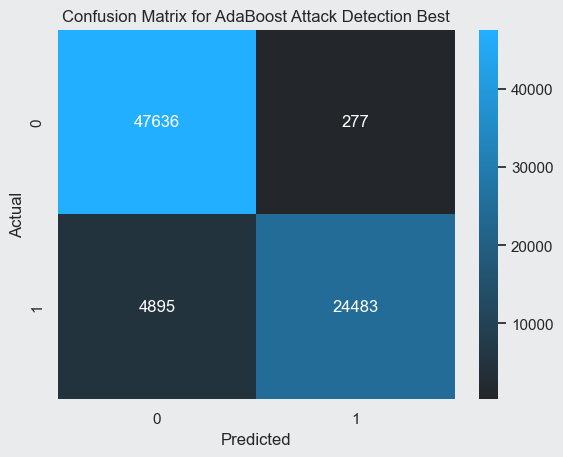

In [14]:
print('Evaluation of AdaBoost Attack Detection Model Best:')
accuracy_ada_attack, fbeta_ada_attack, f1_ada_attack = evaluate_model(ada_model_attack, X_test_attack, y_test_attack, "AdaBoost Attack Detection Best")

In [21]:
# AdaBoost Attack Classification Model
ada_model_class = AdaBoostClassifier(
    algorithm='SAMME',
    learning_rate=0.1,
    n_estimators=200, 
    random_state=404, 
    
    )

# Fit the Model
ada_model_class.fit(X_train_class, y_train_class)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=200,
                   random_state=404)

Evaluation of AdaBoost Attack Classification Model Best:
AdaBoost Attack Classification Best - Accuracy: 0.8661, F-beta Score: 0.8659, F1-Score: 0.8590
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23747
           2       0.47      0.45      0.46      3041
           3       0.87      0.52      0.65      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.87     29378
   macro avg       0.81      0.48      0.51     29378
weighted avg       0.86      0.87      0.86     29378



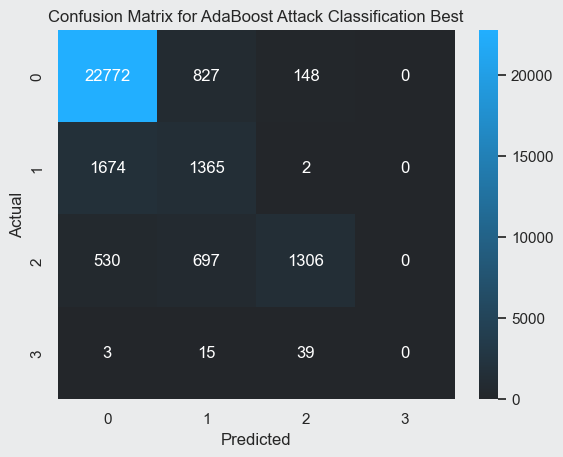

In [22]:
print('Evaluation of AdaBoost Attack Classification Model Best:')
accuracy_ada_class, fbeta_ada_class, f1_ada_class = evaluate_model(ada_model_class, X_test_class, y_test_class, "AdaBoost Attack Classification Best")

# AdaBoost Reduced and Scaled Dataset

In [17]:
# Train and evaluate AdaBoost models

# AdaBoost Attack Detection Model
ada_model_attack_red_scaled = AdaBoostClassifier(
    algorithm='SAMME',
    learning_rate=1.0,
    n_estimators=200, 
    random_state=404, 
    )

# Fit the Model
ada_model_attack_red_scaled.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)

AdaBoostClassifier(algorithm='SAMME', n_estimators=200, random_state=404)

Evaluation of AdaBoost Attack Detection Model Best:
AdaBoost Attack Detection Best - Accuracy: 0.9066, F-beta Score: 0.9066, F1-Score: 0.9070
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     47913
           1       0.86      0.90      0.88     29378

    accuracy                           0.91     77291
   macro avg       0.90      0.91      0.90     77291
weighted avg       0.91      0.91      0.91     77291



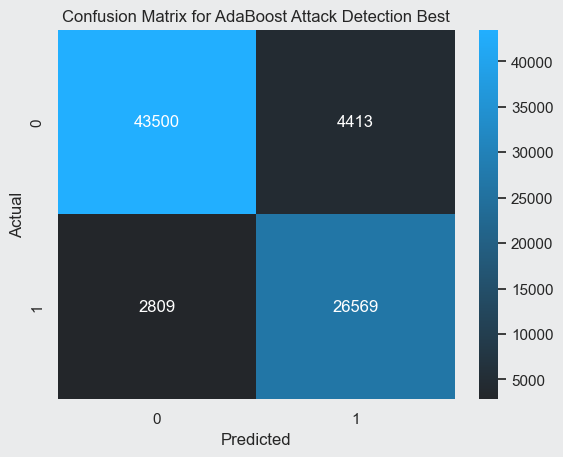

In [18]:
print('Evaluation of AdaBoost Attack Detection Model Best:')
accuracy_ada_attack_red_scaled, fbeta_ada_attack_red_scaled, f1_ada_attack_red_scaled = evaluate_model(
    ada_model_attack_red_scaled, X_test_attack_red_scaled, y_test_attack_red_scaled, "AdaBoost Attack Detection Best")

In [19]:
# AdaBoost Attack Classification Model
ada_model_class_red_scaled = AdaBoostClassifier(
    algorithm='SAMME',
    learning_rate=0.1,
    n_estimators=200, 
    random_state=404, 
    
    )

# Fit the Model
ada_model_class_red_scaled.fit(X_train_class_red_scaled, y_train_class_red_scaled)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=200,
                   random_state=404)

Evaluation of AdaBoost Attack Classification Model Best:
AdaBoost Attack Classification Best - Accuracy: 0.8380, F-beta Score: 0.8376, F1-Score: 0.8278
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23747
           2       0.35      0.64      0.45      3041
           3       0.97      0.10      0.17      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.84     29378
   macro avg       0.82      0.42      0.39     29378
weighted avg       0.89      0.84      0.83     29378



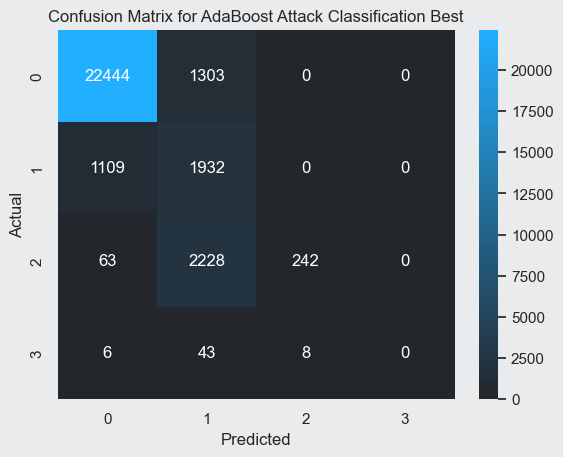

In [20]:
print('Evaluation of AdaBoost Attack Classification Model Best:')
accuracy_ada_class_red_scaled, fbeta_ada_class_red_scaled, f1_ada_class_red_scaled = evaluate_model(
    ada_model_class_red_scaled, X_test_class_red_scaled, y_test_class_red_scaled, "AdaBoost Attack Classification Best")

# Gradient Boosting Full Dataset

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
# Train and evaluate Gradient Boosting models

# Gradient Boosting Attack Detection Model
gb_model_attack = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100, 
    random_state=404
    )


gb_model_attack.fit(X_train_attack, y_train_attack)

GradientBoostingClassifier(max_depth=7, random_state=404)

Evaluation of Gradient Boosting Attack Detection Model:
Gradient Boosting Attack Detection Best - Accuracy: 0.9347, F-beta Score: 0.9347, F1-Score: 0.9335
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



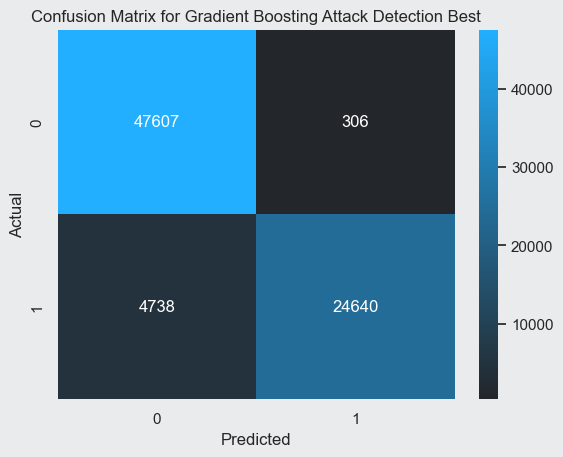

In [25]:
print('Evaluation of Gradient Boosting Attack Detection Model:')
accuracy_gb_attack, fbeta_gb_attack, f1_gb_attack = evaluate_model(gb_model_attack, X_test_attack, y_test_attack, "Gradient Boosting Attack Detection Best")

In [26]:
# Gradient Boosting Attack Classification Model
gb_model_class = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100, 
    random_state=404
    )

gb_model_class.fit(X_train_class, y_train_class)

GradientBoostingClassifier(random_state=404)

Evaluation of Gradient Boosting Attack Classification Model:
Gradient Boosting Attack Classification Best - Accuracy: 0.8825, F-beta Score: 0.8821, F1-Score: 0.8750
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     23747
           2       0.50      0.84      0.63      3041
           3       0.97      0.23      0.37      2533
           4       0.29      0.49      0.36        57

    accuracy                           0.88     29378
   macro avg       0.68      0.63      0.58     29378
weighted avg       0.92      0.88      0.87     29378



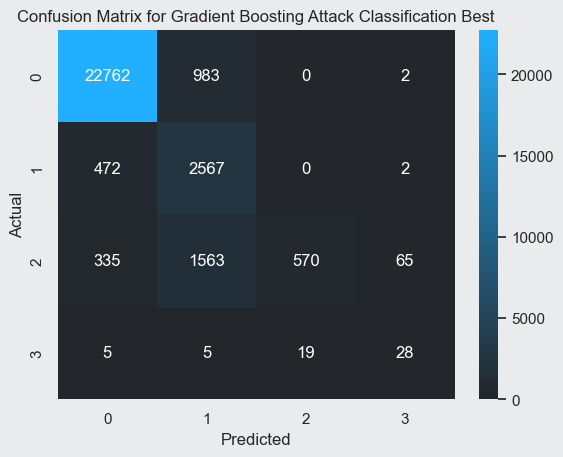

In [27]:
print('Evaluation of Gradient Boosting Attack Classification Model:')
accuracy_gb_class, fbeta_gb_class, f1_gb_class = evaluate_model(gb_model_class, X_test_class, y_test_class, "Gradient Boosting Attack Classification Best")

# Gradient Boosting Reduced and Scaled Dataset

In [28]:
# Train and evaluate Gradient Boosting models

# Gradient Boosting Attack Detection Model
gb_model_attack_red_scaled = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100, 
    random_state=404
    )


gb_model_attack_red_scaled.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)

GradientBoostingClassifier(random_state=404)

Evaluation of Gradient Boosting Attack Detection Model:
Gradient Boosting Attack Detection Best - Accuracy: 0.9243, F-beta Score: 0.9242, F1-Score: 0.9235
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     47913
           1       0.94      0.85      0.90     29378

    accuracy                           0.92     77291
   macro avg       0.93      0.91      0.92     77291
weighted avg       0.93      0.92      0.92     77291



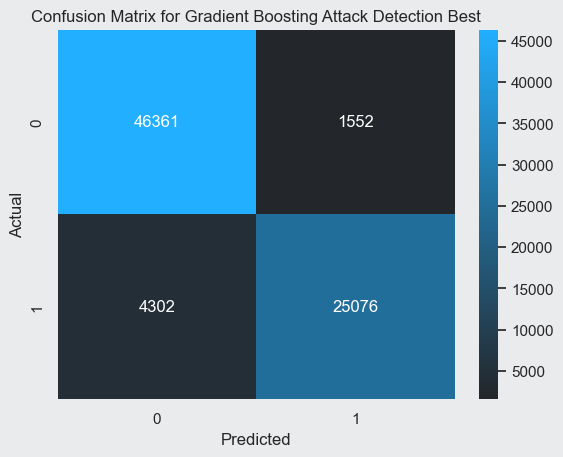

In [29]:
print('Evaluation of Gradient Boosting Attack Detection Model:')
accuracy_gb_attack_red_scaled, fbeta_gb_attack_red_scaled, f1_gb_attack_red_scaled = evaluate_model(
    gb_model_attack_red_scaled, X_test_attack_red_scaled, y_test_attack_red_scaled, "Gradient Boosting Attack Detection Best")

In [30]:
# Gradient Boosting Attack Classification Model
gb_model_class_red_scaled = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100, 
    random_state=404
    )

gb_model_class_red_scaled.fit(X_train_class_red_scaled, y_train_class_red_scaled)

GradientBoostingClassifier(random_state=404)

Evaluation of Gradient Boosting Attack Classification Model:
Gradient Boosting Attack Classification Best - Accuracy: 0.8274, F-beta Score: 0.8268, F1-Score: 0.8188
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     23747
           2       0.41      0.90      0.56      3041
           3       0.08      0.02      0.03      2533
           4       0.17      0.04      0.06        57

    accuracy                           0.83     29378
   macro avg       0.41      0.46      0.40     29378
weighted avg       0.84      0.83      0.82     29378



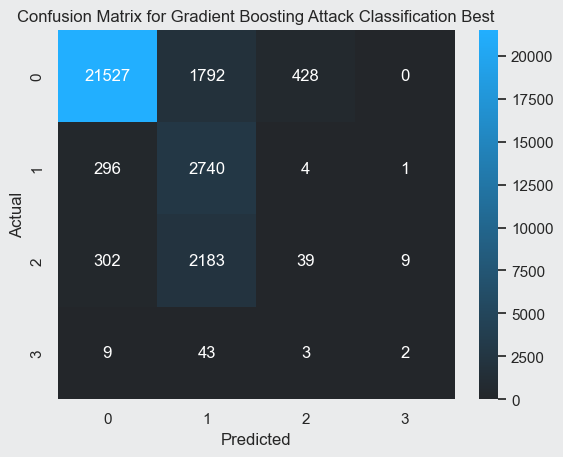

In [31]:
print('Evaluation of Gradient Boosting Attack Classification Model:')
accuracy_gb_class_red_scaled, fbeta_gb_class_red_scaled, f1_gb_class_red_scaled = evaluate_model(
    gb_model_class_red_scaled, X_test_class_red_scaled, y_test_class_red_scaled, "Gradient Boosting Attack Classification Best")